In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

network output is defined as (pg 547):

$$z(t) = \mathbf{w}^T \mathbf{r}(t)$$

network error function (pg 547):

$$e_-(t) = \mathbf{w}^T(t - \Delta t)\mathbf{r}(t) - f(t)$$

nb! this is the error right before the weights are updated at time t. The idea is to update the weights from $\mathbf{w}(t-\Delta t) \text{ to } \mathbf{w}(t)$ in such a way as to reduce the magnitude of $e_-(t)$

So, immediately after the weight update, the netwrok output, **z**, is $\mathbf{w}^T(t)\mathbf{r}(t)$, if the weights are updated fast enough.

So, the error __after__ the weight update is $$ e_+(t) = \mathbf{w}^T(t) \mathbf{r}(t) - f(t) $$


THE goal, then, is to reduce errors in the network by making $$|e_+(t)| < |e_-(t)|$$ and converging to a solution so that the weight vecotr no longer needs to be updated (pg. 548)

this means that $$\frac{e_+(t)}{e_-(t)} \rightarrow 1$$ by the end of training (pg 548)

accomplished by steady but small reduction in $e_-$ and $e_+$ over time, except for the first update which is large (pg 548). So you also want to have $\Delta t$ be pretty short to accomplish this

## Recursive Least Squares

(Why?)

RLS: $$\mathbf{w}(t) = \mathbf{w}(t - \Delta t) - e_-(t) \mathbf{P}(t) \mathbf{r}(t)$$

where **P** is an NxN matrix that is updated at the same time as the weights according to the rule: 
$$\mathbf{P}(t) = \mathbf{P}(t - \Delta t) - \frac{\mathbf{P}(t - \Delta t) \mathbf{r}(t) \mathbf{r}^T \mathbf{P}(t - \Delta t)}{1 + \mathbf{r}^T(t)\mathbf{P}(t - \Delta t) \mathbf{r}(t)}$$

Where $$\mathbf{P}(0) = \frac{\mathbf{I}}{\alpha}$$
Where **I** is the identity matrix, and $\alpha$ is a constant (pg. 548)

Where **P** acts a a multidimensional learning rate for the 'delta' type learning rule. So, for this algorithm, **P** is a "Running estimate  of the inverse of teh correlation matrix of the network rates **r** plus a regularization term: $$\mathbf{P} = \left( \sum_t \mathbf{r}(t)\mathbf{r}^T(t) + 
\alpha \mathbf{I} \right)$$

For subsequent timesteps, the equation above imply that: $$e_+(t) = e_-(t)(1 - \mathbf{r}^T (t) \mathbf{P}(t)\mathbf{r}(t))$$
(pg 548) so the quantity $\mathbf{r}^T\mathbf{P}\mathbf{r}$ varies from around 1 to assymptotically approaching 0 over the course of training, and is always positive

$\alpha$ acts as the learning rate, and should be adjusted depending on the target function. (pg548). small values for $\alpha$ result in fast learning but sometimes can become unstable. But, if $\alpha$ is too big, FORCE might not be able to keep the output close to the target for long enough. use between 1 and 100 (pg 548)

Learning generally takes about $1000 \tau$ where $\tau$ is the basic time constant of the network, which they set to around 10ms. So basically it takes around 10 seconds of simulated time for teh network to converge (549)

"To encompass all the models, we write the newtwork equations for the generator network as: 
$$\tau \frac{dx_i}{dt} = -x_i + g_{GG} \sum_{j = 1}^{N_G}J_{ij}^{GG} r_j + g_{G_z} J_{i} ^{G_z} z + g_{GF} \sum_{a = 1}^{N_F} J_{ia}^{GF} s_a + \sum_{\mu = 1}^{N_I} J_{i \mu}^{GI} I_\mu$$

for $i = 1, 2, .. <1,2,..>, N_G$ with firing rates $r_i = \tanh(x_i$) (pg 556)

For figure 2 and 3, the parameters are:

$$N_G = 1000\\
p_{GG} = 0.1\\
p_Z = 1\\
g_{Gz} = 1\\
g_{GF} = 0\\
\alpha = 1.0\\
N_I = 0\\
\tau = 10ms$$

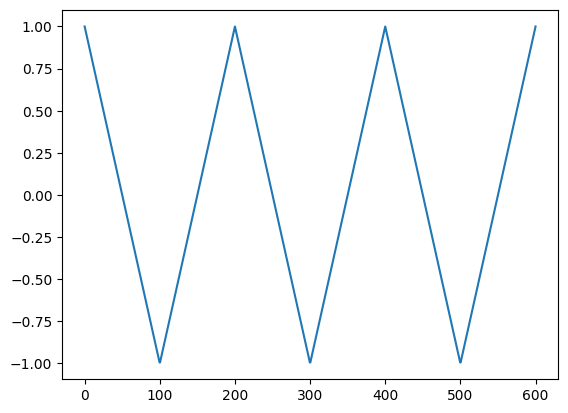

In [58]:
t = np.linspace(0, 600, 1000)
triangle = -signal.sawtooth(2 * np.pi * 5 * t, 0.5)
plt.plot(t, triangle)

In [82]:
alpha = 1.0
P_init = np.identity(1000)/alpha

In [83]:
P_init.size

1000000

In [59]:
neurons = np.zeros((1000))

In [60]:
func_to_aprox = triangle
P_init = 

In [61]:
def inverse_corr_matrix_estimate_update(P, network_state, timestep):
    P = P
    P[timestep] = (P[timestep - 1] - P[timestep - 1] * network_state * network_state.T * P[timestep - 1])\
    /1 + network_state.T * P[timestep - 1] * network_state
    return P

def


1000